In [1]:
import torch
class DQNPolicy:
    def __init__(self, n_actions, station_space, n_hidden = 128, lr=0.005):
        super().__init__()
        self.n_actions = n_actions

        self.dqn = torch.nn.Sequential(
            torch.nn.Linear(station_space, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_actions)
        )
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=0.001)

    def make_action(self, state, eps=0):
        with torch.no_grad():
            best_action = torch.argmax(self.dqn(torch.Tensor(state)))
            if torch.rand((1,)).item() > eps:
                return best_action.item()
            return torch.randint(self.n_actions, (1,)).item()


    def update(self, state, next_state, action, reward, gamma=1):
        q_values = self.dqn(torch.Tensor(state))
        q_values_next = self.dqn(torch.Tensor(next_state))

        q_values_should_be = self.dqn(torch.Tensor(state)).tolist().copy()
        q_values_should_be[action] = reward + gamma*torch.max(q_values_next).item()

        self.optimizer.zero_grad()
        self.loss(q_values, torch.Tensor(q_values_should_be)).backward()
        self.optimizer.step()

In [2]:
import tqdm as tqdm
import matplotlib.pyplot as plt
def learn_policy(env, n_episodes, policy, t_max=500):
    total_rewards = []

    for _ in tqdm(range(n_episodes)):
        state, _ = env.reset()
        is_done = False
        total_reward = 0
        # t = 0
        while not is_done: # and t < t_max:
            action = policy.make_action(state, eps=0.1)
            next_state, reward, is_done, truncated, _ = env.step(action)
            total_reward += reward

            policy.update(state, next_state, action, reward)
            state = next_state
            # t += 1
        total_rewards.append(total_reward)
        plt.plot(total_rewards)
    return total_rewards

In [3]:
import gym
import gym_game
env = gym.make('Parkme')
reset, _ = env.reset()
n_actions = env.action_space.n
states_dim = env.observation_space.shape[0]
print(n_actions, states_dim)
policy = DQNPolicy(env.action_space.n, states_dim)

5 7


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
100%|██████████| 1000/1000 [09:34<00:00,  1.74it/s]


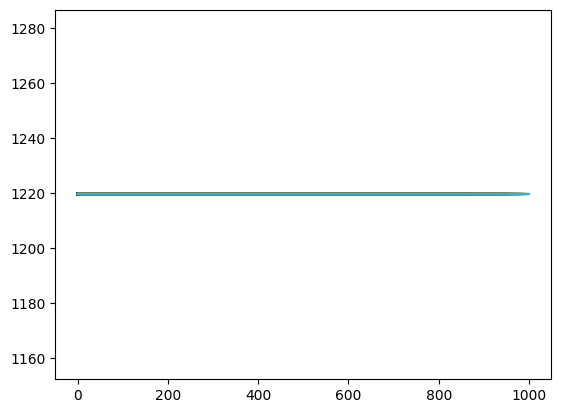

In [4]:
total_rewards = learn_policy(env, 1000, policy)

In [5]:
torch.save(policy.dqn.state_dict(), 'torch.pt')